In [2]:
import pandas as pd
import numpy as np
import math

import spotipy
import spotipy.util as util
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import preprocessing

# Clustering saved songs into playlists

A client ID and client password is required to get authorization for Spotipy. You will have to register your app at https://developer.spotify.com/dashboard/login under 'My Dashboard' to get your personal client_ID and client_secret. When editing app settings, set the redirect_uri as https://google.com/ to match the cell below. 

Since we want to accesss our saved songs, we set the scope as 'user-library-read'. After running the cell, you will be redirected to the site you set as 'redirect_uri'. Copy the link of the site after you are redirected and paste the link where prompted below this cell. 

#### Important note: I have removed any personal user or account information (username, client_id, client_secret). If you wish to replicate this project, make sure you fill in those variables with your own credentials.

In [ ]:
# Get token for authorization 
import spotipy.util as util

# Enter personal username and ids
username = ''
client_id = ''
client_secret = ''

username = username
scope = 'user-library-read'
client_id = client_id
client_secret = client_secret
redirect_uri='https://google.com/'
token = util.prompt_for_user_token(username,
                           scope,
                           client_id=client_id,
                           client_secret=client_secret,
                           redirect_uri='https://google.com/')

if token:
    sp = spotipy.Spotify(auth=token)

### Populate a dataframe with your saved songs. 

In [ ]:
username = ''

id_test = sp.user_playlist_tracks(username, 'capjqw9g4pf7ft0ds00y30oxm:playlist:0ZuQXoVLRwcMEgRyi6HxVD')['items'][0]['track']['id']
columns = ['artist', 'track']
list(map(lambda x: columns.append(x), list(sp.audio_features(id_test)[0].keys()))) # Get columns for song features
row_counter = 0

tracks = pd.DataFrame(columns = columns, index = range(0, 502)) #Set range to length of saved tracks
tracks["Popularity"] = np.nan # Create a column for popularity
tracks["added_at"] = np.nan # Create a column for date added
 
off = 0
song_list = []
for i in range(0,502):
    track = sp.current_user_saved_tracks(limit=1, offset=off)['items'][0] #Only read one song at a time and increase offset (index) every time
    current_id = track['track']['id']
    current_row = [track['track']['artists'][0]['name'], track['track']['name']] 
    (list(map(lambda x: current_row.append(x), list(sp.audio_features(current_id)[0].values())))) # Use song ID to get song features
    current_row.append(track['track']['popularity'])
    current_row.append(track['added_at'])
    song_list.append(current_row)
    tracks.iloc[i] = current_row
    off += 1

In [ ]:
saved_tracks = tracks.copy()
saved_tracks.to_csv("saved_tracks.csv")

# Data Import

In [3]:
saved_tracks = pd.read_csv("saved_tracks.csv", index_col = 0)

# Drop columns that aren't needed for clustering
saved_tracks.drop(['type', 'track_href','analysis_url'], axis = 1, inplace = True)

# Change data types of columns
saved_tracks = saved_tracks.astype({'danceability': float,
                                        'energy': float,
                                        'key': int,
                                        'loudness': float,
                                        'mode': int,
                                        'speechiness': float,
                                        'acousticness': float,
                                        'instrumentalness': float,
                                        'liveness': float,
                                        'valence': float,
                                        'tempo': float,
                                        'duration_ms': float,
                                        'time_signature': float})


# Change the date feature to the datatype date time
saved_tracks['added_at'] = pd.to_datetime(saved_tracks['added_at'])

# Create a columns for month and year
saved_tracks['Month'] = saved_tracks['added_at'].dt.month_name().str.slice(stop=3)
saved_tracks['Year'] = saved_tracks['added_at'].dt.year

# Group tracks by month and year
year_month = saved_tracks.groupby(['Year', 'Month']).agg('count')
date = year_month['added_at'].to_frame()
date = date.rename(columns = {'added_at':'num_songs'})

# Exploratory Data Analysis

In [61]:
saved_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502 entries, 0 to 501
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   artist            502 non-null    object             
 1   track             502 non-null    object             
 2   danceability      502 non-null    float64            
 3   energy            502 non-null    float64            
 4   key               502 non-null    int64              
 5   loudness          502 non-null    float64            
 6   mode              502 non-null    int64              
 7   speechiness       502 non-null    float64            
 8   acousticness      502 non-null    float64            
 9   instrumentalness  502 non-null    float64            
 10  liveness          502 non-null    float64            
 11  valence           502 non-null    float64            
 12  tempo             502 non-null    float64            
 13  id   

Summary Statistics of Features

In [4]:
saved_tracks.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Popularity,Year
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,0.689098,0.614588,5.149402,-6.336289,0.547809,0.128764,0.225211,0.005687,0.172285,0.443106,120.332639,204906.952191,3.964143,61.934263,2019.372510
std,0.145033,0.149228,3.654160,2.224102,0.498206,0.104616,0.228637,0.039116,0.128110,0.201219,28.471730,46742.041622,0.344198,22.846831,0.667675
min,0.218000,0.231000,0.000000,-17.540000,0.000000,0.024300,0.000177,0.000000,0.031600,0.035200,59.989000,97297.000000,1.000000,0.000000,2018.000000
25%,0.606750,0.521250,1.000000,-7.569500,0.000000,0.048225,0.041625,0.000000,0.095025,0.308250,98.006500,174706.750000,4.000000,56.000000,2019.000000
50%,0.703000,0.623000,5.000000,-6.136000,1.000000,0.082550,0.153500,0.000000,0.118000,0.434000,117.937000,201996.500000,4.000000,68.000000,2019.000000
75%,0.798750,0.714750,8.000000,-4.755500,1.000000,0.193250,0.334750,0.000009,0.208750,0.570750,140.070500,226737.250000,4.000000,77.000000,2020.000000
max,0.974000,0.941000,11.000000,-0.938000,1.000000,0.502000,0.946000,0.482000,0.959000,0.939000,202.006000,467053.000000,5.000000,100.000000,2020.000000


What artists artists show up the most in my saved songs?

In [62]:
saved_tracks.artist.value_counts().to_frame()[:10]

,artist
Jhené Aiko,10
Rihanna,10
The Weeknd,8
G-Eazy,7
Post Malone,7
Megan Thee Stallion,6
Kanye West,6
Marc E. Bassy,6
Cardi B,6
Pop Smoke,5


Examining the relationships between song features with a heatmap

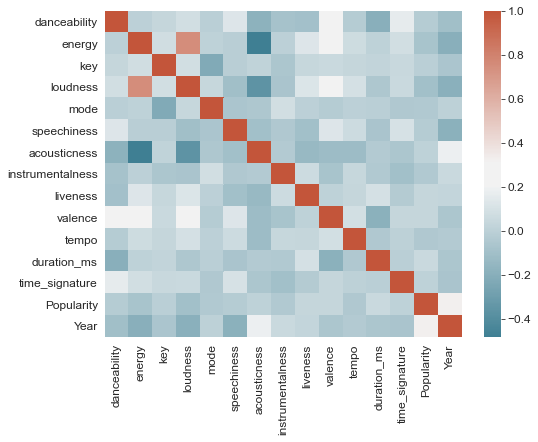

In [63]:
import seaborn as sns
import matplotlib

fig, ax = plt.subplots(figsize = (8,6))
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(saved_tracks.corr(), cmap = cmap)  

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=12)

What are the highest energy songs that I've saved?

In [64]:
saved_tracks.sort_values('energy', ascending = False)[['artist', 'track', 'energy']][:10]

,artist,track,energy
262,Wilkinson,Sweet Lies,0.941
424,GASHI,Creep On Me (feat. French Montana & DJ Snake) ...,0.934
435,Skrillex,HUMBLE. - SKRILLEX REMIX,0.934
364,Lost Kings,Don't Kill My High,0.932
429,RL Grime,UCLA - Heimanu Remix,0.925
416,R3HAB,Up All Night,0.916
486,Big Sean,Ashley,0.915
278,Fabolous,You Be Killin Em,0.909
501,Drake,Nice For What,0.909
405,Gucci Mane,Love Thru The Computer (feat. Justin Bieber),0.908


See when songs were added

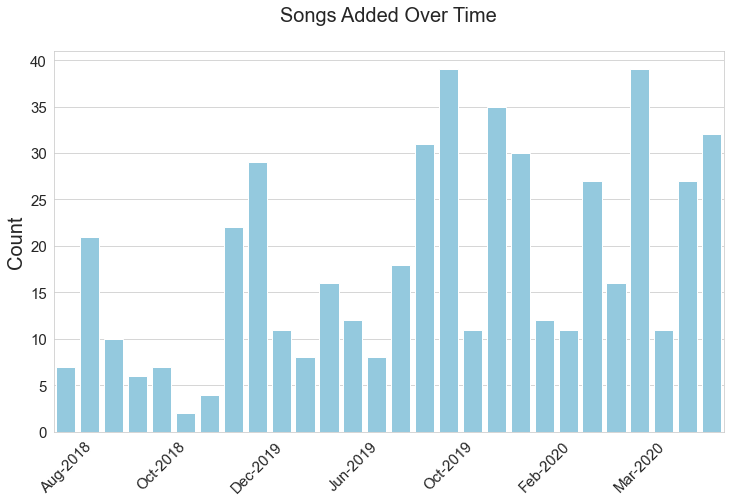

In [66]:
fig, ax = plt.subplots(figsize = (12,7))

fig = sns.barplot(x = date.index.values, y = date.num_songs, data = date, color = 'skyblue')

labels = [f'{i[1]}-{i[0]}' for i in date.index.values]
ax.set_xticklabels(labels = labels,rotation = 45, fontsize = 15)
ax.set_xlabel('')

plt.yticks(fontsize= 15)
ax.set_ylabel(ylabel = 'Count', size = 20)

ax.set_title('Songs Added Over Time', size = 20, pad = 30, fontname = 'sans-serif')

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        


# K Means Clustering 

### Use the elbow method to find the best K. Try k values 1-21.

In [5]:
# Drop columns not used for modeling
saved_tracks.drop(columns = ["added_at", "Month", "duration_ms"], axis = 0, inplace = True)

# Create dummy variables for Year
onehotencoder = OneHotEncoder()
saved_tracks = pd.get_dummies(saved_tracks, columns = ['Year'])

# Scale features that don't already have values between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
col_features = ['danceability', 'key',
                'energy','loudness', 'tempo', 'Popularity', 'time_signature']
saved_tracks[col_features] = MinMaxScaler().fit_transform(saved_tracks[col_features])

In [78]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,21) 
for k in K:
    model = KMeans(n_clusters=k)
    model = model.fit(saved_tracks.drop(["artist", "track", "id", "uri"], axis = 1))
    Sum_of_squared_distances.append(model.inertia_)
    print(f'Completed:{k}')

Completed:1
Completed:2
Completed:3
Completed:4
Completed:5
Completed:6
Completed:7
Completed:8
Completed:9
Completed:10
Completed:11
Completed:12
Completed:13
Completed:14
Completed:15
Completed:16
Completed:17
Completed:18
Completed:19
Completed:20


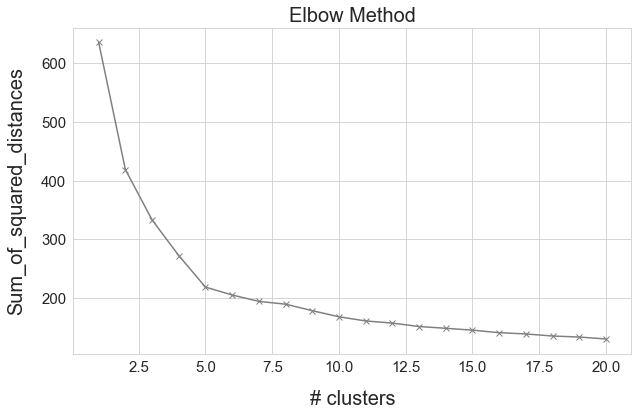

In [79]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
plt.plot(list(range(1,21)),Sum_of_squared_distances,'bx-', color = 'grey')

plt.ylabel('Sum_of_squared_distances', fontsize = 20, labelpad = 15)
plt.xlabel('# clusters', fontsize = 20, labelpad = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Elbow Method", fontsize = 20)

plt.show()
#4 looks to be an appropriate number

/Users/briannamueller/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

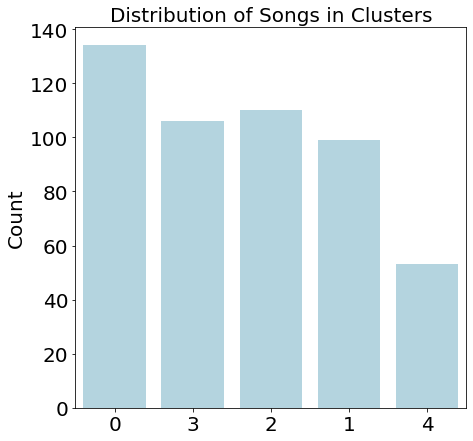

In [6]:
# Choose the number of cluster 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5)
model = kmeans.fit(saved_tracks.drop(["artist", "track", "id", "uri"], axis = 1))

# See the distribution of songs in each cluster
import seaborn as sns
plt.figure(figsize = (7,7))
sns.countplot([str(group) for group in kmeans.labels_], color = 'lightblue')

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Distribution of Songs in Clusters", fontsize = 20)
plt.ylabel("Count", fontsize = 20)

The smallest cluster has about 50 songs while the largest cluster has about 180 songs. I think that 50 songs is enough for a playlsit and 180 isn't too many songs for a playlist so I am okay with this k value.

# Visualize the clusters - PCA

Text(0, 0.5, 'PC2: 0.11')

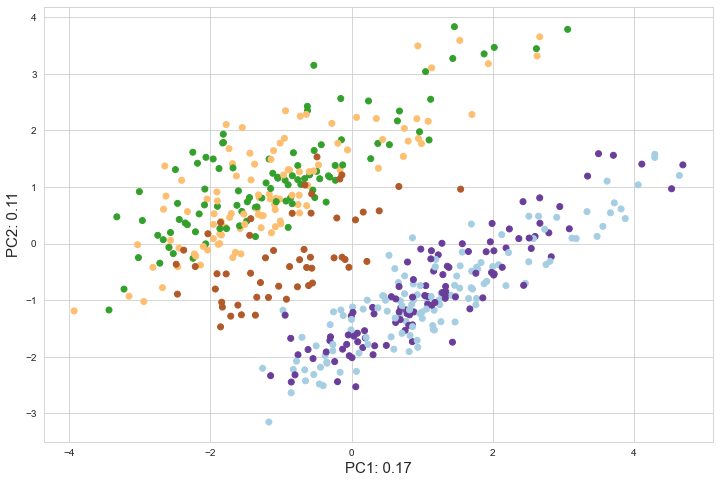

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(saved_tracks.drop(["artist", "track", "id", "uri"], axis = 1))
scaled_data = scaler.transform(saved_tracks.drop(["artist", "track", "id", "uri"], axis = 1))

from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)

pca_corr = pd.DataFrame(pca.components_, columns = saved_tracks.drop(['artist', 'track', 'id', 'uri'], axis = 1).columns)

sns.set_style('whitegrid')

plt.figure(figsize = (12, 8))
plt.scatter(data_pca[:,0], data_pca[:,1], c = list(kmeans.labels_), cmap = 'Paired')
plt.xlabel('PC1: {:.2f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.2f}'.format(pca.explained_variance_ratio_[1]), size = 15)

It is difficult to distinguish between clusters so this visual doesn't give us much information. We can try a third component.

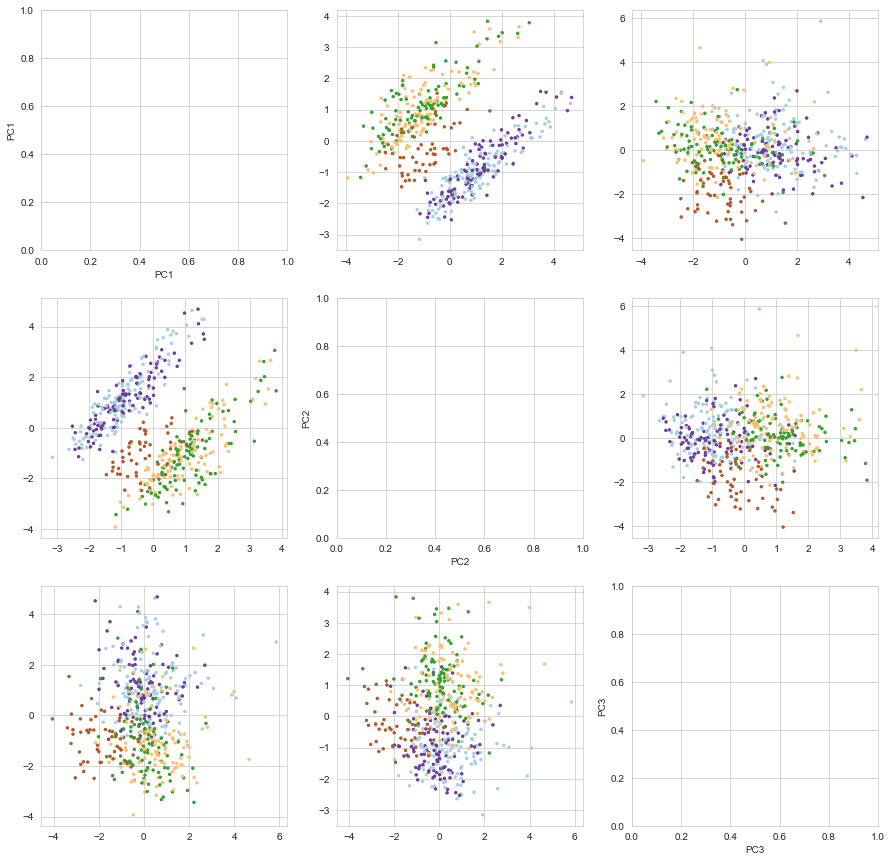

In [8]:
pca = PCA(n_components = 3)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)

sns.set_style('whitegrid')
fig, ax = plt.subplots(3,3,figsize = (15,15), squeeze = False)

for x in range(0,3):
    for y in range(0,3):
        if x != y:
            ax[x, y].scatter(data_pca[:,x], data_pca[:,y], c = list(kmeans.labels_), cmap = 'Paired', s = 6)
        else:
            ax[x,y].set_ylabel('PC{}'.format(x+1))
            ax[x,y].set_xlabel('PC{}'.format(x+1))
            continue

<ipython-input-9-b0d2f4c0afa1>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


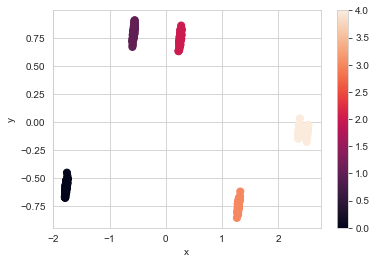

In [9]:
predictions = model.predict(saved_tracks.drop(["artist", "track", "id", "uri"], axis = 1))
saved_tracks['group'] = predictions

pca_result = pca.fit_transform(saved_tracks.drop(['artist', 'track', 'id', 'uri'], axis = 1))
df=pd.DataFrame(pca_result)
df['cluster']= predictions
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(df.iloc[:,0].values, df.iloc[:,1].values,c= predictions,s=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)

fig.show()

### Look at the attributes of each cluster

In [10]:
saved_tracks[saved_tracks['group'] == 0].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Popularity,Year_2018,Year_2019,Year_2020,group
count,134.000000,134.000000,134.000000,134.000000,134.0,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.0,134.0,134.0,134.0
mean,0.615148,0.485674,0.373134,0.654002,1.0,0.102926,0.266978,0.010220,0.184683,0.419243,0.411827,0.735075,0.674403,0.0,0.0,1.0,0.0
std,0.191273,0.208443,0.312595,0.127404,0.0,0.100101,0.244209,0.053329,0.146231,0.197561,0.186772,0.095781,0.173693,0.0,0.0,0.0,0.0
min,0.067460,0.000000,0.000000,0.147814,1.0,0.024300,0.000278,0.000000,0.031600,0.035200,0.009309,0.000000,0.020000,0.0,0.0,1.0,0.0
25%,0.498347,0.324296,0.090909,0.581300,1.0,0.039875,0.072925,0.000000,0.094900,0.280000,0.274957,0.750000,0.572500,0.0,0.0,1.0,0.0
50%,0.622354,0.490141,0.363636,0.656457,1.0,0.057500,0.188000,0.000000,0.112500,0.405500,0.400896,0.750000,0.690000,0.0,0.0,1.0,0.0
75%,0.769180,0.635211,0.636364,0.752063,1.0,0.116750,0.424750,0.000013,0.216500,0.542750,0.528699,0.750000,0.797500,0.0,0.0,1.0,0.0
max,0.948413,0.911268,1.000000,0.928744,1.0,0.416000,0.946000,0.418000,0.720000,0.919000,0.902012,1.000000,0.970000,0.0,0.0,1.0,0.0


In [11]:
saved_tracks[saved_tracks['group'] == 1].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Popularity,Year_2018,Year_2019,Year_2020,group
count,99.000000,99.000000,99.000000,99.000000,99.0,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.0,99.0,99.0,99.0
mean,0.613543,0.578831,0.588613,0.703508,0.0,0.137983,0.217909,0.001259,0.187520,0.443465,0.399491,0.752525,0.554444,0.0,1.0,0.0,1.0
std,0.195202,0.211748,0.331956,0.131587,0.0,0.096473,0.218106,0.007902,0.141788,0.185855,0.204332,0.091019,0.248392,0.0,0.0,0.0,0.0
min,0.021164,0.061972,0.000000,0.249368,0.0,0.028200,0.000926,0.000000,0.065900,0.060500,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0
25%,0.521164,0.447887,0.363636,0.636911,0.0,0.059650,0.051650,0.000000,0.095850,0.345500,0.253779,0.750000,0.520000,0.0,1.0,0.0,1.0
50%,0.633598,0.576056,0.636364,0.706120,0.0,0.100000,0.137000,0.000000,0.127000,0.463000,0.366576,0.750000,0.630000,0.0,1.0,0.0,1.0
75%,0.771164,0.712676,0.909091,0.790266,0.0,0.214500,0.307000,0.000017,0.221000,0.542000,0.559292,0.750000,0.725000,0.0,1.0,0.0,1.0
max,0.921958,1.000000,1.000000,1.000000,0.0,0.359000,0.945000,0.072600,0.959000,0.939000,0.929339,1.000000,0.880000,0.0,1.0,0.0,1.0


In [12]:
saved_tracks[saved_tracks['group'] == 2].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Popularity,Year_2018,Year_2019,Year_2020,group
count,110.000000,110.000000,110.000000,110.000000,110.0,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.0,110.0,110.0,110.0
mean,0.608369,0.603406,0.437190,0.699474,1.0,0.134130,0.171754,0.009044,0.159985,0.464467,0.432593,0.731818,0.553182,0.0,1.0,0.0,2.0
std,0.184227,0.216095,0.339369,0.137332,0.0,0.105033,0.211410,0.056785,0.116607,0.212585,0.212047,0.105519,0.247416,0.0,0.0,0.0,0.0
min,0.097884,0.070423,0.000000,0.309360,1.0,0.028900,0.000177,0.000000,0.035000,0.063300,0.105938,0.000000,0.000000,0.0,1.0,0.0,2.0
25%,0.485780,0.456690,0.090909,0.622982,1.0,0.048300,0.019375,0.000000,0.094600,0.312000,0.263724,0.750000,0.455000,0.0,1.0,0.0,2.0
50%,0.626984,0.619718,0.454545,0.721148,1.0,0.088550,0.078550,0.000000,0.117000,0.434000,0.365808,0.750000,0.655000,0.0,1.0,0.0,2.0
75%,0.728175,0.768310,0.727273,0.787300,1.0,0.211750,0.229500,0.000003,0.187250,0.606750,0.605810,0.750000,0.737500,0.0,1.0,0.0,2.0
max,1.000000,0.990141,1.000000,0.924708,1.0,0.425000,0.858000,0.482000,0.696000,0.892000,1.000000,0.750000,0.840000,0.0,1.0,0.0,2.0


In [13]:
saved_tracks[saved_tracks['group'] == 3].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Popularity,Year_2018,Year_2019,Year_2020,group
count,106.000000,106.000000,106.000000,106.000000,106.0,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0,106.0,106.0,106.0
mean,0.614643,0.493994,0.514580,0.635013,0.0,0.123374,0.269536,0.003382,0.162161,0.443851,0.438539,0.738208,0.730943,0.0,0.0,1.0,3.0
std,0.198295,0.189746,0.317380,0.136383,0.0,0.102395,0.245619,0.014647,0.116144,0.224517,0.199661,0.053252,0.134338,0.0,0.0,0.0,0.0
min,0.000000,0.022535,0.000000,0.000000,0.0,0.027800,0.001150,0.000000,0.059500,0.038400,0.037925,0.500000,0.170000,0.0,0.0,1.0,3.0
25%,0.557870,0.375352,0.363636,0.544618,0.0,0.049450,0.069975,0.000000,0.095100,0.277750,0.283526,0.750000,0.670000,0.0,0.0,1.0,3.0
50%,0.648810,0.517606,0.545455,0.658324,0.0,0.079650,0.205000,0.000000,0.114500,0.409000,0.440194,0.750000,0.740000,0.0,0.0,1.0,3.0
75%,0.738095,0.629577,0.795455,0.731779,0.0,0.191250,0.411750,0.000022,0.192500,0.625000,0.575686,0.750000,0.810000,0.0,0.0,1.0,3.0
max,0.932540,0.883099,1.000000,0.848994,0.0,0.467000,0.945000,0.111000,0.790000,0.883000,0.843624,0.750000,1.000000,0.0,0.0,1.0,3.0


In [14]:
saved_tracks[saved_tracks['group'] == 4].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Popularity,Year_2018,Year_2019,Year_2020,group
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.0,53.0,53.0,53.0
mean,0.708970,0.567739,0.454545,0.702509,0.584906,0.176517,0.155548,0.000138,0.158255,0.456943,0.462211,0.759434,0.515472,1.0,0.0,0.0,4.0
std,0.173791,0.187944,0.321412,0.117004,0.497454,0.116852,0.162375,0.000958,0.090755,0.161322,0.202468,0.048095,0.288501,0.0,0.0,0.0,0.0
min,0.232804,0.145070,0.000000,0.358391,0.000000,0.033700,0.001510,0.000000,0.058600,0.186000,0.098714,0.750000,0.000000,1.0,0.0,0.0,4.0
25%,0.611111,0.433803,0.181818,0.631852,0.000000,0.074900,0.030500,0.000000,0.093600,0.342000,0.281361,0.750000,0.320000,1.0,0.0,0.0,4.0
50%,0.723545,0.542254,0.454545,0.718588,1.000000,0.150000,0.083900,0.000000,0.118000,0.451000,0.478929,0.750000,0.650000,1.0,0.0,0.0,4.0
75%,0.835979,0.702817,0.727273,0.780087,1.000000,0.240000,0.278000,0.000001,0.227000,0.543000,0.605266,0.750000,0.720000,1.0,0.0,0.0,4.0
max,0.968254,0.963380,1.000000,0.883809,1.000000,0.502000,0.608000,0.006980,0.385000,0.927000,0.985537,1.000000,0.880000,1.0,0.0,0.0,4.0


Compare the cluster means 

In [16]:
# Put mean values in the same dataframe
means = pd.DataFrame(index = range(0,5), 
                    columns = list(saved_tracks[saved_tracks['group'] == 0].describe().loc['mean'].index))
means.iloc[0] = saved_tracks[saved_tracks['group'] == 0].describe().loc['mean']
means.iloc[1] = saved_tracks[saved_tracks['group'] == 1].describe().loc['mean']
means.iloc[2] = saved_tracks[saved_tracks['group'] == 2].describe().loc['mean']
means.iloc[3] = saved_tracks[saved_tracks['group'] == 3].describe().loc['mean']
means.iloc[4] = saved_tracks[saved_tracks['group'] == 4].describe().loc['mean']
means[["danceability", "energy", "liveness", "tempo", "acousticness", "instrumentalness", "key", "Popularity"]]

,danceability,energy,liveness,tempo,acousticness,instrumentalness,key,Popularity
0,0.615148,0.485674,0.184683,0.411827,0.266978,0.0102198,0.373134,0.674403
1,0.613543,0.578831,0.18752,0.399491,0.217909,0.00125879,0.588613,0.554444
2,0.608369,0.603406,0.159985,0.432593,0.171754,0.00904367,0.43719,0.553182
3,0.614643,0.493994,0.162161,0.438539,0.269536,0.00338181,0.51458,0.730943
4,0.70897,0.567739,0.158255,0.462211,0.155548,0.00013841,0.454545,0.515472


Initial observations: Cluster 4 has the highest average danceability score and cluster 3 has the highest average popularity score.

# Create the playlists

In [90]:
# Get token for authorization 
import spotipy.util as util

# Fill in user credentials
username = ''
client_id = ''
client_secret = ''

username = user
scope = 'playlist-modify-public'
client_id = client_id
client_secret = client_secret
redirect_uri='https://google.com/'
token = util.prompt_for_user_token(username,
                           scope,
                           client_id=client_id,
                           client_secret=client_secret,
                           redirect_uri='https://google.com/')

if token:
    sp = spotipy.Spotify(auth=token)

In [97]:
# Get user ID, not username 
user = ''

playlist0 = saved_tracks[saved_tracks.group == 0]
playlist1 = saved_tracks[saved_tracks.group == 1]
playlist2 = saved_tracks[saved_tracks.group == 2]
playlist3 = saved_tracks[saved_tracks.group == 3]
playlist4 = saved_tracks[saved_tracks.group == 4]

playlists = ["playlist0", "playlist1", "playlist2", "playlist3", "playlist4"]
playlist_dfs = [playlist0, playlist1, playlist2, playlist3, playlist4]

# Create emtpy playlists
for playlist_name in playlists:
    sp.user_playlist_create(user = user, name=playlist_name)

# Create a dictionary of the user's playlist names and their associated playlistIDs
user_playlists = sp.user_playlists(user = user) 
playlist_dict = {}
for item in user_playlists['items']:
    id = item['id']
    name = item['name']
    playlist_dict[name] = id
    
# From the dictionary, pull the playlistIDs of the playlists we are interested in filling with tracks
playlistIDs = []

for playlist in playlists:
    if playlist in playlist_dict:
        playlistIDs.append(playlist_dict[playlist])


for i in range(len(playlist_dfs)):
    playlist = playlist_dfs[i]
    start = 0
    finish = 50
    while ((len(playlist_dfs[i]) - finish)+50) > 50:
        tracks = list(playlist.id[start:finish])
        sp.user_playlist_add_tracks(user, playlistIDs[i], tracks, position = None)
        start += 50
        finish += 50
    else:
        tracks = list(playlist.id[start:])
        sp.user_playlist_add_tracks(user, playlistIDs[i], tracks, position = None)
        print(f'{len(playlist)} tracks were added to {playlists[i]}.')

134 tracks were added to playlist0.
99 tracks were added to playlist1.
106 tracks were added to playlist2.
110 tracks were added to playlist3.
53 tracks were added to playlist4.


### You can go find your new playlists on Spotify!